In [29]:
import os
import pandas as pd

# Caminho para a pasta de imagens
images_path = '/teamspace/studios/this_studio/unsupervised_disaster/extracted_data/images'

# Função para processar os nomes das imagens
def process_image_metadata(images_folder):
    data = []

    # Iterar sobre todos os arquivos na pasta de imagens
    for filename in os.listdir(images_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Separar informações do nome da imagem
            parts = filename.split('_')
            disaster_type = parts[0]  # Exemplo: 'guatemala-volcano' ou 'socal-fire'
            disaster_status = "Com desastre" if "post" in parts[-2] else "Sem desastre"
            image_reference = os.path.splitext(filename)[0]  # Nome sem extensão
            
            # Adicionar informações à lista
            data.append({
                "Image Reference": image_reference,
                "Image Name": filename,
                "Disaster Type": disaster_type,
                "Disaster Status": disaster_status
            })
    
    # Criar DataFrame
    df = pd.DataFrame(data)
    return df

# Processar imagens e criar DataFrame
image_metadata_df = process_image_metadata(images_path)

In [30]:
image_metadata_df.shape

(5598, 4)

In [31]:
# Contagem por tipo de desastre natural
disaster_counts = image_metadata_df['Disaster Type'].value_counts()

# Contagem de imagens com desastre e sem desastre (total e por tipo de desastre)
status_counts_total = image_metadata_df['Disaster Status'].value_counts()
status_counts_by_disaster = image_metadata_df.groupby(['Disaster Type', 'Disaster Status']).size()

# Exibir os resultados
print("Contagem por tipo de desastre natural:")
print(disaster_counts)

print("\nContagem total de imagens com desastre e sem desastre:")
print(status_counts_total)

print("\nContagem de imagens com desastre e sem desastre por tipo de desastre:")
print(status_counts_by_disaster)

Contagem por tipo de desastre natural:
Disaster Type
socal-fire             1646
hurricane-michael       686
hurricane-harvey        638
hurricane-florence      638
midwest-flooding        558
hurricane-matthew       476
santa-rosa-wildfire     452
mexico-earthquake       242
palu-tsunami            226
guatemala-volcano        36
Name: count, dtype: int64

Contagem total de imagens com desastre e sem desastre:
Disaster Status
Com desastre    2799
Sem desastre    2799
Name: count, dtype: int64

Contagem de imagens com desastre e sem desastre por tipo de desastre:
Disaster Type        Disaster Status
guatemala-volcano    Com desastre        18
                     Sem desastre        18
hurricane-florence   Com desastre       319
                     Sem desastre       319
hurricane-harvey     Com desastre       319
                     Sem desastre       319
hurricane-matthew    Com desastre       238
                     Sem desastre       238
hurricane-michael    Com desastre       3

In [32]:
# Lista das classes desejadas
classes_desejadas = ['santa-rosa-wildfire', 'palu-tsunami', 'hurricane-michael']

# Filtrar o dataset para conter apenas as classes desejadas
image_metadata_df = image_metadata_df[image_metadata_df['Disaster Type'].isin(classes_desejadas)]

# Exibir as primeiras linhas do dataset filtrado
print(image_metadata_df.head())

                               Image Reference  \
1788  hurricane-michael_00000000_post_disaster   
1789   hurricane-michael_00000000_pre_disaster   
1790  hurricane-michael_00000001_post_disaster   
1791   hurricane-michael_00000001_pre_disaster   
1792  hurricane-michael_00000003_post_disaster   

                                        Image Name      Disaster Type  \
1788  hurricane-michael_00000000_post_disaster.png  hurricane-michael   
1789   hurricane-michael_00000000_pre_disaster.png  hurricane-michael   
1790  hurricane-michael_00000001_post_disaster.png  hurricane-michael   
1791   hurricane-michael_00000001_pre_disaster.png  hurricane-michael   
1792  hurricane-michael_00000003_post_disaster.png  hurricane-michael   

     Disaster Status  
1788    Com desastre  
1789    Sem desastre  
1790    Com desastre  
1791    Sem desastre  
1792    Com desastre  


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [34]:
# Configurações gerais
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preparação dos dados
df = image_metadata_df.copy()
df['Image Path'] = df['Image Name'].apply(lambda x: os.path.join(images_path, x))
df['Label'] = df['Disaster Status'].map({'Com desastre': 1, 'Sem desastre': 0})

# Filtrar apenas imagens com desastre
df = df[df['Label'] == 1].reset_index(drop=True)

# Divisão em treino e validação
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

In [35]:
# Classe que o GPT criou para organizar o dataset
class DisasterDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image Path']
        label = self.dataframe.iloc[idx]['Label']
        disaster_type = self.dataframe.iloc[idx]['Disaster Type']
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        # Retorna também o disaster_type (string)
        return image, torch.tensor(label, dtype=torch.float32), disaster_type


In [36]:
# Transformações 
data_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [37]:
# Criar datasets e dataloaders
train_dataset = DisasterDataset(train_df, transform=data_transforms)
val_dataset = DisasterDataset(val_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Soma o atalho à saída convolucional
        out = F.relu(out)
        return out

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64, stride=1)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 256, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Log-variance

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 256 * 7 * 7)  # Expand to 7x7x256
        self.decoder_layer1 = ResidualBlock(256, 128, stride=1)
        self.decoder_layer2 = ResidualBlock(128, 64, stride=1)
        self.decoder_output = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 256, 7, 7)  # Reshape para 7x7x256
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # 14x14
        x = self.decoder_layer1(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # 28x28
        x = self.decoder_layer2(x)
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)  # 224x224
        x = self.decoder_output(x)
        x = torch.sigmoid(x)  # Saída normalizada
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z  # Retorna o vetor latente


In [43]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstrução: MSE ou BCE
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # Divergência KL
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div


In [46]:
from tqdm import tqdm

vae = ConvVAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
epochs = 5

# Armazenar vetores latentes e rótulos
latent_vectors = []
labels = []
disaster_types = []

for epoch in range(epochs):
    vae.train()
    epoch_loss = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
        for X, y, dt in train_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            recon, mu, logvar, z = vae(X)
            loss = vae_loss(recon, X, mu, logvar)
            epoch_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Salvar vetores latentes e rótulos para t-SNE
            latent_vectors.append(mu.cpu().detach().numpy())
            labels.append(y.cpu().numpy())
            disaster_types.append(dt)
        
            # Atualizar barra de progresso
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/5:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 1/5: 100%|██████████| 18/18 [05:12<00:00, 17.34s/batch, loss=8.19e+4]


Epoch 1, Loss: 3901281.2895


Epoch 2/5: 100%|██████████| 18/18 [05:16<00:00, 17.61s/batch, loss=8.68e+4]


Epoch 2, Loss: 3310163.1393


Epoch 3/5: 100%|██████████| 18/18 [05:24<00:00, 18.04s/batch, loss=4.68e+4]


Epoch 3, Loss: 3307437.3602


Epoch 4/5: 100%|██████████| 18/18 [05:11<00:00, 17.33s/batch, loss=6.78e+4]


Epoch 4, Loss: 3305859.9905


Epoch 5/5: 100%|██████████| 18/18 [04:44<00:00, 15.80s/batch, loss=4.96e+5]

Epoch 5, Loss: 3304760.5000


In [47]:
vectors = latent_vectors.copy()

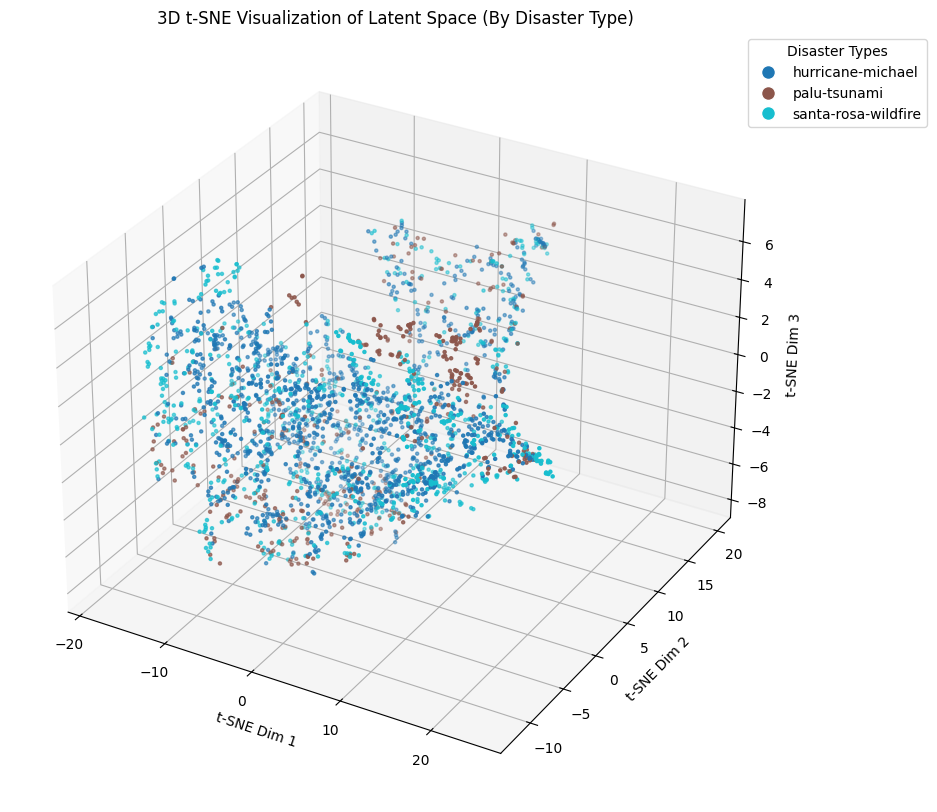

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

vector = np.concatenate(latent_vectors, axis=0)
disaster_types = np.concatenate(disaster_types, axis=0)  # Agora temos um array de strings (nomes do desastre)

# Salvar o espaço latente com disaster_type
latent_data = pd.DataFrame(vector, columns=[f"dim_{i+1}" for i in range(vector.shape[1])])
latent_data['Disaster Type'] = disaster_types
latent_data.to_csv("latent_space.csv", index=False)

# Aplicar t-SNE
tsne = TSNE(n_components=3, random_state=42)
z_3d = tsne.fit_transform(vector)

# Cada disaster_type terá uma cor
unique_classes = np.unique(disaster_types)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
class_color_map = {cls: colors[i] for i, cls in enumerate(unique_classes)}
class_colors = [class_color_map[dt] for dt in disaster_types]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c=class_colors, s=5)
ax.set_title("3D t-SNE Visualization of Latent Space (By Disaster Type)")
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")

# Criar legenda com disaster_types
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) 
           for i, cls in enumerate(unique_classes)]
ax.legend(handles, unique_classes, title="Disaster Types", loc="upper right", bbox_to_anchor=(1.2, 1))

plt.show()
